##### Concept Similarity with WN 

Consegna 1.1

Mario Scapellato 


##### dati in input due termini, il task di conceptual similarity consiste nel fornire un punteggio numerico di similarità che ne indichi la vicinanza semantica.
##### Ad esempio, la similarity fra i concetti car e bus potrebbe essere di 0.8 in una scala [0,1], in cui 0 significa che i sensi sono completamente diversi mentre 1 che sono completamente identici. Per risolvere il task di concept similarity e' possibile sfruttare la struttura ad albero di wordnet


In [177]:
import nltk
import csv
from nltk.corpus import wordnet as wn
import math
from scipy import stats as st

L'input dell'esercitazione e' costituito da coppie di termini contenuti nel file WordSim353 in cui ci sono 353 coppue di termini in cui a ciascuna coppia e' associato un valore numerico tra 0 e 10 che ne indicia la similarity tra le coppie

In [178]:
#read csv of WordSim353
def read_csv(file):
    col = []

    with open (file, "r", encoding='utf-8-sig') as f:
        csv_file = csv.reader(f, delimiter='')

        for c in csv_file:
            col.append(c)
    
    return col

Calcolare tre misure di similarity basate su WordNet e poi per ciascuna calcolare gli indici di correlazione di Spearman e di Pearson fra i risultati ottenuti e quelli presenti nel file annotato

In [179]:
"""
#calcolo la similarità tra due sensi tramite path similarity tra 2 synset andando a vedere quanto 2 sensi sono simili
def sentence_similairty(synset_1, synset_2):
    max_similarity = 0
    sys_1 = wn.synsets(synset_1)
    sys_2 = wn.synsets(synset_2)

    if len(sys_1) == 0 or len(sys_2) == 0:
        return None, None
    else:
        max_similarity = 0
        best_pair = None,None
        for s1 in sys_1:
            for s2 in sys_2:
                sim = wn.path_similarity(s1,s2)
                if sim > max_similarity:
                    max_similarity= sim
                    best_pair = s1, s2
        
        return best_pair
"""

'\n#calcolo la similarità tra due sensi tramite path similarity tra 2 synset andando a vedere quanto 2 sensi sono simili\ndef sentence_similairty(synset_1, synset_2):\n    max_similarity = 0\n    sys_1 = wn.synsets(synset_1)\n    sys_2 = wn.synsets(synset_2)\n\n    if len(sys_1) == 0 or len(sys_2) == 0:\n        return None, None\n    else:\n        max_similarity = 0\n        best_pair = None,None\n        for s1 in sys_1:\n            for s2 in sys_2:\n                sim = wn.path_similarity(s1,s2)\n                if sim > max_similarity:\n                    max_similarity= sim\n                    best_pair = s1, s2\n        \n        return best_pair\n'

In [180]:
#depth(x) e' una funzione che misura la distanza tra la radice di wordnet e il synset x
def depth(distance):
    return  min([len(path) for path in distance.hypernym_paths()])

Lowest Common Subsumer :  il Least Common Subsumer di due concetti A e B è "il concetto più specifico che è un antenato sia di A che di B", dove l'albero dei concetti è definito dalla is-a relazione. Un concetto è definito come un antenato di un altro concetto.

For example:

A car is an automobile, and an automobile is a vehicle
A boat is a vehicle.
Vehicle is an object.

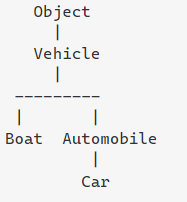


In this case, "automobile" is the parent (and also ancestor) of "car", while "vehicle" is an ancestor of "car". "Vehicle" is also an ancestor of "boat". In this case, the LCS of "boat" and "car" is "vehicle", since it's the most specific concept which is an ancestor of both "boat" and "car". Note that while "object" is a common subsumer of both "boat" and "car", it is not the least, since there is still a child of "object" (in this case it's "vehicle") which is also a common subsumer of both "car" and "boat". "Automobile" is not the least common subsumer since it's not an ancestor of "boat".

In [181]:
def lcs(syn1, syn2):
    paths1 = syn1.hypernym_paths() #iperonimi di syn1
    paths2 = syn2.hypernym_paths() #iperonimi di syn2
    lcs =  None
    min_path = math.inf
    for i in range(0, len(paths1)):
        for j in range(0, len(paths2)):
            n = min(len(paths1[i]), len(paths2[j])) - 1 #min length path (-1 because the first index is 0) #serve per calcolare il cammino minore  tra 2 concetti
            #print("Paths 1", paths1[i])
            #print("Paths 2", paths2[j])
            #print("min lenght path:", n)
            
            current_path = abs(len(paths1[i]) - len(paths2[j])) # initial distance from lcs

            #print("current path:", current_path)
            while n >= 0 and current_path < min_path:
                if paths1[i][n] == paths2[j][n]: #se i synset sono uguali
                    lcs = paths1[i][n]
                    min_path = current_path #perche sono uguali i synset
                n -= 1 #go up in the tree
                current_path += 2 #+2 because we are going up in the tree

            #print("lcs:", lcs)
    return (lcs, min_path)

#### Wu Palmer
##### Calcola la correlazione considerando le profondità dei due synset nelle tassonomie di WordNet, insieme alla profondità dell'LCS (Least Common Subsumer). Il punteggio può essere 0 < punteggio <= 1. Il punteggio non può mai essere zero perché la profondità dell'LCS non è mai zero (la profondità della radice della tassonomia è uno). Calcola la somiglianza in base a quanto sono simili i sensi delle parole e dove si trovano i Synset l'uno rispetto all'altro nell'albero degli ipernimi. 

$$cs(s1,s2) = 2*depth(LCS)/depth(s1)+depth(s2)$$

Si prende la profondita dell'antenato comune e lo si divide per la profondita' di ciascun senso

In [182]:
def wu_palmer(s1,s2):
    lcs_pair = lcs(s1,s2)
    
    lcs_val = lcs_pair[0]
    if lcs_val:
        #The depth of a concept is simply its distance to the root node.
        lcs_depth = depth(lcs_val)
        #print("lcs depth:", lcs_depth)
        formula = 2 * lcs_depth / (2 * lcs_depth + lcs_pair[1])

        return formula
    return 0

In [183]:
#return: massima profondita' dell'iperonimo alla radice. Esempio : dog.n.01 ha una max_depth di 14 
max_depth =  max(max(len(hyp_path) for hyp_path in ss.hypernym_paths()) for ss in wn.all_synsets())
#print(max_depth)

##### Shortest Path

Prova a calcolare il percorso minimo tra due sensi

$$sim(s1,s2) = 2*depthMax - len(s1,s2)$$


We have 3 options:

1) if len(s1 ,s2) is 0, sim path (s1 ,s2) gets the maximum value of 2* depthMax.

2) if len(s1 ,s2) is 2* depthMax, sim path (s1 ,s2) gets the minimum value of 0.

3) thus, the values of sim path (s1 ,s2) are between 0 and 2* depthMax.

In [184]:
def compute_shortest_path(synset_1, synset_2):

    len = lcs(synset_1, synset_2)
    #print(len)

    if len is None:
        return 0
        
    if len == 0:
        sim = 2*max_depth
        
    if len == 2*max_depth:
        sim = 0
    
    sim = (2*max_depth - len[1])

    return (sim/40) * 10 


#### Leakcock & Chodorow

##### è una misura di similarità semantica lessicale che trova il percorso più breve tra due concetti e scala tale valore per la lunghezza massima del percorso.

$$sim(s1,s2) = -log(len(s1,s2)/2*depthMax)$$

In [185]:
def compute_leakcock(synset_1, synset_2):

    len = lcs(synset_1,synset_2)

    if len[0]:
        formula = - math.log((len[1] + 1)/(2 * max_depth + 1), 10)
    
        return formula
    return 0

In [186]:
lines = []
with open('WordSim353.csv', "r") as f:
    for i in f.readlines(): 
        lines.append(i.strip().split(','))

pearson Usa i punteggi mentre Spearman si concentra sui ranghi 
Pearson Misura la CORRELAZIONE LINEARE tra due variabili X e Y, mentre Spearman si concentra sui ranghi e quindi su una misurazione basata su funzione monotona

In [187]:
wu = []
shortest_path = []
leakcock = []
score = []

for i in range (1, len(lines)-1):
    score.append(float(lines[i][2]))
    sys_1 = wn.synsets(lines[i][0])
    sys_2 = wn.synsets(lines[i][1])

    max_sim_wp = 0
    max_sim_sp = 0
    max_sim_lk= 0

    for s1 in sys_1:
        for s2 in sys_2:
            wp = wu_palmer(s1,s2)
            max_sim_wp = max(max_sim_wp,wp) #Prendo la massima similarita fra i sensi del primo termine e tutti i sensi del secondo perche devo calcolare la similarita fra 2 termini, mentre le formule utilizano i sensi

            sp = compute_shortest_path(s1,s2)
            max_sim_sp = max(max_sim_sp, sp) #stessa cosa di prima. Massimizzo il punteggio di somiglianza

            lk = compute_leakcock(s1,s2)
            max_sim_lk = max(max_sim_lk, lk) #stessa cosa di prima
    
    #la massimizzazione e' quella che effettua la disambiguazione tra i due contesti minimali
    wu.append(max_sim_wp)
    shortest_path.append(max_sim_sp)
    leakcock.append(max_sim_lk)

    #print(s)


print("Pearson for Wu_palmer : ", st.pearsonr(wu, score)[0]) 
print("Spearman for Wu_Palmer: ", st.spearmanr(wu,score)[0])
print("Pearson for shortest_path : ", st.pearsonr(shortest_path, score)[0])
print("Spearman for Shortest_path : ", st.spearmanr(shortest_path,score)[0])
print("Pearson for Leakock  : ", st.pearsonr(leakcock, score)[0])
print("Spearman for Leakock :", st.spearmanr(leakcock, score)[0]) 

Pearson for Wu_palmer :  0.28437726262888385
Spearman for Wu_Palmer:  0.33456798917863056
Pearson for shortest_path :  0.16521122548534714
Spearman for Shortest_path :  0.288553673195581
Pearson for Leakock  :  0.3128950733147109
Spearman for Leakock : 0.288553673195581


In [188]:
from prettytable import PrettyTable

table_res = PrettyTable(["Line_1", "Line_2", "Score", "Leakcock & Chodorow", "Wu & Palmer", "Shortest-path"])

for i in range(1, len(lines)-1):
    table_res.add_row([lines[i][0], lines[i][1], score[i-1] , leakcock[i-1], wu[i-1], shortest_path[i-1]])

print(table_res)

+---------------+----------------+-------+---------------------+---------------------+---------------+
|     Line_1    |     Line_2     | Score | Leakcock & Chodorow |     Wu & Palmer     | Shortest-path |
+---------------+----------------+-------+---------------------+---------------------+---------------+
|      love     |      sex       |  6.77 |  1.3117538610557542 |  0.9230769230769231 |      9.75     |
|     tiger     |      cat       |  7.35 |  1.3117538610557542 |  0.9655172413793104 |      9.75     |
|     tiger     |     tiger      |  10.0 |  1.6127838567197355 |         1.0         |      10.0     |
|      book     |     paper      |  7.46 |  1.135662602000073  |        0.875        |      9.5      |
|    computer   |    keyboard    |  7.62 |  1.010723865391773  |  0.8235294117647058 |      9.25     |
|    computer   |    internet    |  7.58 |  0.7096938697277918 |  0.631578947368421  |      8.25     |
|     plane     |      car       |  5.77 |  0.7676858167054786 |  0.72727

Notiamo che la Correlazione di Pearson per tutte le metriche e' una quantita' positiva, facendo capire che il valore di una variabile aumenta con le altre, misurando appundo la correlazione lineare tra 2 variabili. Tuttavia, per metriche come WU Palmer e Shortest Path, la correlazione di Spearman ha mostrato dei risultati appena migliori, questo puo essere dovuto da come sono distribuiti i dati, mostrando in questo caso che all'aumentare di x aumenta anche y. Se ci fosse stato punteggio minore di 1, avremmo detto che all'aumentare di x, y diminuisce